# DIPSHIFT Fitter

In [23]:
#@title Setup fitter
import sys
if 'google.colab' in sys.modules:
    !pip install sleepy-nmr
else:
    sys.path.append('/Users/albertsmith/Documents/GitHub/')
    sys.path.append('/Users/albertsmith/Documents/GitHub.nosync/')
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

dHC=sl.Tools.dipole_coupling(.109,'1H','13C')
tetra=np.arccos(-1/3)

class DIPSHIFT():
    def __init__(self,nH:int=1,vr:float=5000,N:int=17,dHX=dHC,n_alpha:int=100,n_beta:int=50,n_gamma:int=100):
        super().__setattr__('nH',nH)
        self.dHX=dHX

        # self.ex=sl.ExpSys(v0H=500,Nucs=['13C',*['1H']*nH],
        #                   pwdavg=sl.PowderAvg('grid',n_alpha=n_alpha,n_beta=n_beta),n_gamma=n_gamma)

        self.ex=sl.ExpSys(v0H=500,Nucs=['13C',*['1H']*nH],
                          pwdavg=sl.PowderAvg('rep144'),n_gamma=256)

        beta=0 if nH==1 else (tetra/2 if nH==2 else tetra)

        for k in range(nH):
            self.ex.set_inter('dipole',i0=0,i1=k+1,delta=1,euler=[0,beta,k*2*np.pi/nH])

        H=self.ex.Hamiltonian()[0]
        self.Azz=np.array([Hi.rotInter.Azz[:,[0,1,3,4]]/np.sqrt(6) for Hi in H.Hinter])

        self.N=N
        self.vr=vr


    def __setattr__(self,name,value):
        assert name not in ['nH'],f'{name} cannot be set after initialization'
        if name in ['N','vr']:
            self._xt=None
        super().__setattr__(name,value)

    @property
    def tau(self):
        return np.arange(self.N)*1/(self.vr*(self.N-1))

    @property
    def exp(self):
        return np.array([1j/(q*2*np.pi*self.vr)*(np.exp(-1j*q*self.tau*2*np.pi*self.vr)-1) for q in [-2,-1,1,2]]).T

    @property
    def xt(self):
        if self._xt is None:
            self._xt=np.array([[(Azz0*exp0).sum(-1).real for Azz0 in self.Azz] for exp0 in self.exp],dtype=float)
        return self._xt


    def I(self,S):
        omegat=np.cos(2*np.pi*self.dHX*S*self.xt)
        I=(omegat.prod(1)*self.ex.pwdavg.weight).sum(-1)
        return I

    def plot(self,S=None,ax=None,I=None):
        if ax is None:ax=plt.subplots()[1]
        assert S is not None or I is not None,'S or I must be defined'

        if S is None:S=self.fit(I)

        ax.plot(self.tau*self.vr,self.I(S))
        ax.set_xlabel(r'$\tau*\nu_r$')
        if I is not None:
            ax.scatter(self.tau*self.vr,I,marker='x',color='black')
            ax.text(0,.05,f'S={S:.3f}')
        ax.set_ylim([min([0,ax.get_ylim()[0]]),max([1,ax.get_ylim()[1]])])
        return ax

    def fit(self,I):
        def fun(S):
            return ((self.I(S)-I)**2).sum()
        return np.abs(least_squares(fun, 0, xtol=None,gtol=None)['x'][0])

def DS(nH,vr=5000,N=17,DSobj=[None,None,None]):
    assert nH in [1,2,3],"nH must be 1, 2, or 3"
    if DSobj[nH-1] is None:
        DSobj[nH-1]=DIPSHIFT(nH=nH)
    out=DSobj[nH-1]
    out.vr=vr
    out.N=N
    return out

## Generate test data

In [50]:
nH=1
N=17
S=0.5
vr=5000
noise=.05

I=DS(nH,vr,N).I(S)+np.random.randn(N)*noise

## Input experimental data

In [51]:
# I=[]
# N=len(I)
# vr=5000

## Fit data

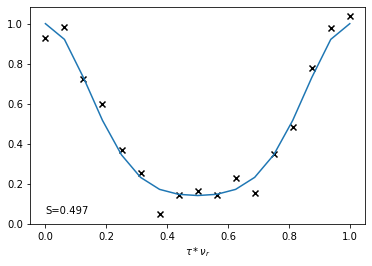

In [52]:
ds=DS(nH,vr,N)
S=ds.fit(I)
_=DS(nH,vr,N).plot(S=S,I=I)

## Compare curves for different numbers of spins

### 1 spin vs. 2 spins
We generate 2-spin curves and fit them to the 1-spin curves. We also plot the input S vs. the fitted S.

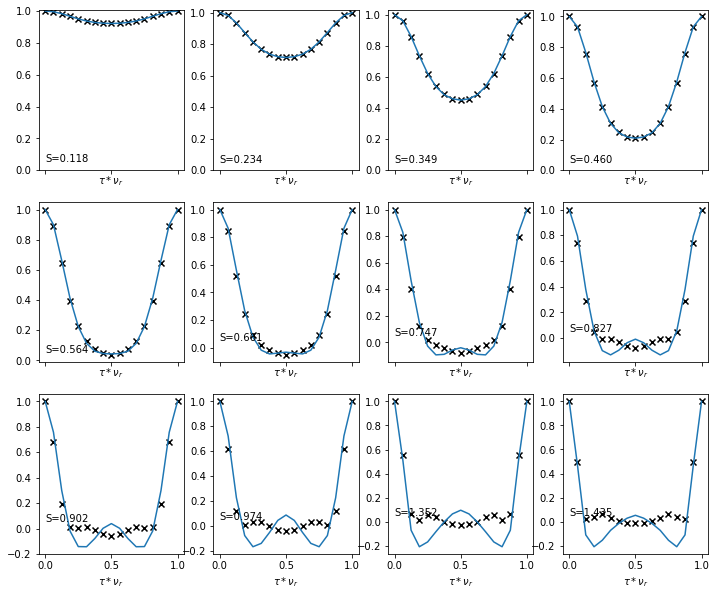

In [36]:
ds1=DS(1,vr,N)
ds2=DS(2,vr,N)

S0=np.linspace(0,1,13)[1:]
fig,ax=plt.subplots(3,4,sharex=True,figsize=[12,10])
ax=ax.flatten()

Sfit=[]

for S,a in zip(S0,ax):
    I=ds2.I(S=S)
    Sfit.append(ds1.fit(I=I))
    ds1.plot(I=I,S=Sfit[-1],ax=a)

#### Plot $S_{input}$ vs. $S_{fit}$

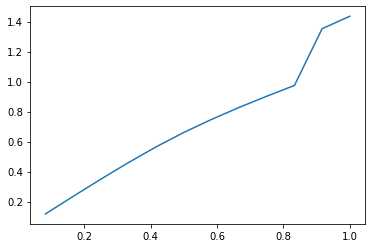

In [37]:
ax=plt.subplots()[1]
_=ax.plot(S0,Sfit)

### 1 spin vs. 3 spins
We generate 3-spin curves and fit them to the 1-spin curves. We also plot the input S vs. the fitted S.

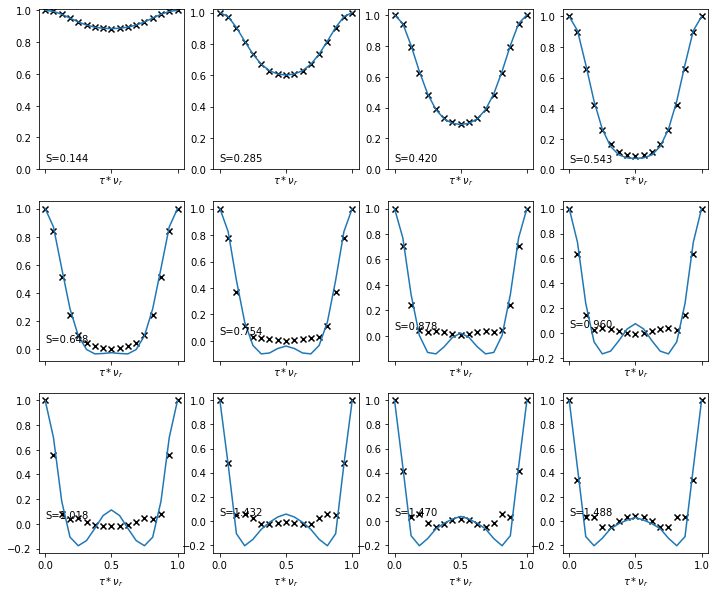

In [38]:
ds1=DS(1,vr,N)
ds3=DS(3,vr,N)

S0=np.linspace(0,1,13)[1:]
fig,ax=plt.subplots(3,4,sharex=True,figsize=[12,10])
ax=ax.flatten()

Sfit=[]

for S,a in zip(S0,ax):
    I=ds3.I(S=S)
    Sfit.append(ds1.fit(I=I))
    ds1.plot(I=I,S=Sfit[-1],ax=a)

#### Plot $S_{input}$ vs. $S_{fit}$

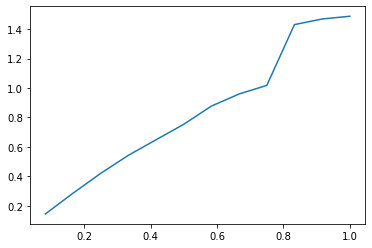

In [39]:
ax=plt.subplots()[1]
_=ax.plot(S0,Sfit)